## DCF ANALYSIS

Use 'Valuation_1' to get 5 yrs avg growth rate, sector avg growth rate etc.

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_rows', None)

In [2]:
#additional Data Points
t = 4 # years of available data
# Define the time period
start = datetime.datetime.now() - datetime.timedelta(days=365)
end = datetime.datetime.now()

# Fetch the 10-year Treasury yield from FRED
treasury_yield = web.DataReader('GS10', 'fred', start, end)

# Get the latest value
risk_free_rate = treasury_yield.iloc[-1]['GS10'] / 100  # Convert from percentage to decimal
print(f'Latest 10-Year Treasury Yield: {risk_free_rate:.2%}')

Latest 10-Year Treasury Yield: 3.87%


In [3]:
snp_ticker = '^GSPC'  # S&P 500 Index
snp = yf.Ticker(snp_ticker)
years = 'max'
snp_history = snp.history(period= years)

# Calculate the historical market return
snp_return = snp_history['Close'].pct_change().dropna()
market_return = np.mean(snp_return) * 252  # Annualize the return
print(f'{years}  Historical AVG Market Return: {market_return:.2%}')

max  Historical AVG Market Return: 7.80%


In [4]:
#Stock To Analyze
# Fetch the stock data
ticker = 'CPNG'
stock = yf.Ticker(ticker)

In [5]:
#Get Stock Beta
stock_info = stock.info
beta = stock_info['beta']

# Balance sheet, cash_flow and income_statement
balance_sheet = stock.balance_sheet
cash_flow = stock.cashflow
income_statement = stock.financials
#
financials = stock.financials

print('Stock Beta: ', beta)

Stock Beta:  1.102


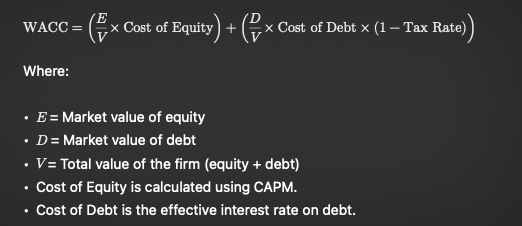

In [6]:
# Cost of Debt
interest_expense = financials.loc['Interest Expense']   # 
average_debt = stock.balance_sheet.loc['Long Term Debt']   # 
cost_of_debt = (interest_expense / average_debt).mean()  # Average cost of debt


def calculate_cost_of_equity(risk_free_rate, beta, market_return):
    return risk_free_rate + beta * (market_return - risk_free_rate)

cost_of_equity = calculate_cost_of_equity(risk_free_rate, beta, market_return)

# Market Value of Equity
stock_price = stock.history(period='1d')['Close'].iloc[-1]
shares_outstanding = stock.info['sharesOutstanding']
market_value_of_equity = stock_price * shares_outstanding

# Market Value of Debt
market_value_of_debt = balance_sheet.loc['Long Term Debt'].sum()   # in million USD

# Tax Rate Calculation with fallback to calculate EBIT if not available
try:
    # If EBIT is available
    ebit = income_statement.loc['EBIT']
except KeyError:
    # Fallback to calculate EBIT from Net Income, Interest Expense, and Taxes
    net_income = income_statement.loc['Net Income']
    interest_expense = income_statement.loc['Interest Expense']
    taxes = income_statement.loc['Income Tax Expense'] if 'Income Tax Expense' in income_statement.index else 0  # Use 0 if not available

    # EBIT Calculation: EBIT = Net Income + Interest Expense + Taxes
    ebit = net_income + interest_expense + taxes

# Tax Rate Calculation using EBIT (either from income statement or calculated)
if 'Tax Rate For Calcs' in income_statement.index:
    tax_rate = income_statement.loc['Tax Rate For Calcs'] / (ebit - interest_expense)
else:
    # Use a default or estimated tax rate if not available in the data
    tax_rate = 0.21  # Assume a default tax rate (e.g., 21% in the US)

# Take the mean if needed across periods
tax_rate = tax_rate.mean()  # Average tax rate

# Calculate WACC
def calculate_wacc(cost_of_equity, cost_of_debt, market_value_of_equity, market_value_of_debt, tax_rate):
    equity_weight = market_value_of_equity / (market_value_of_equity + market_value_of_debt)
    debt_weight = market_value_of_debt / (market_value_of_equity + market_value_of_debt)
    wacc = (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))
    return wacc

wacc = calculate_wacc(cost_of_equity, cost_of_debt, market_value_of_equity, market_value_of_debt, tax_rate)
###########
print('WACC: {:.2f}%'.format(wacc * 100))
print('MKT VALUE OF EQUITY (MUSD): ${:,.2f}'.format(market_value_of_equity / 1_000_000))
print('COST OF EQUITY: {:.2f}%'.format(cost_of_equity * 100))

WACC: 8.32%
MKT VALUE OF EQUITY (MUSD): $40,342.99
COST OF EQUITY: 8.20%


In [7]:
# Terminal Value Calculation

growth_rate = 0.01  # use 5 Yrs Sector Growth Value from analysis on Yahoo from 'Valuation4'
final_year_cash_flow = cash_flow.loc['Free Cash Flow'].iloc[0]   # in million USD
terminal_value = final_year_cash_flow * (1 + growth_rate) / (wacc - growth_rate)

# Discount Terminal Value to Present Value
discounted_terminal_value = terminal_value / ((1 + wacc) ** t)

# Calculate Intrinsic Share Price
intrinsic_value = (discounted_terminal_value) / shares_outstanding

# Actual Share Price
actual_share_price = stock_price

**Growth Rate Calculation**: It allows you to assess how sensitive the intrinsic value of the stock is to changes in growth rates. This can provide valuable insights for investment decisions based on the relative valuation of the stock compared to its current market price.

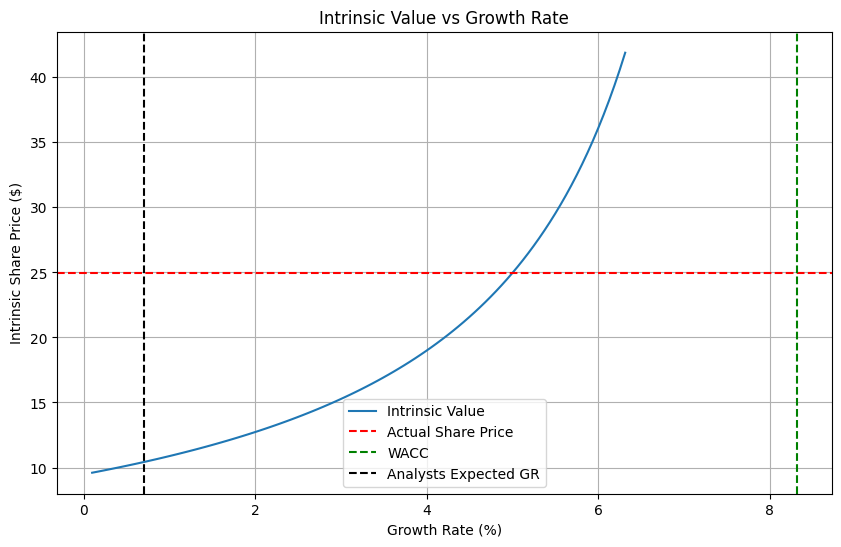

Implied growth rate at the actual share price is approximately: 5.00%
Intrinsic Share Price at 0.10% growth rate: $9.60
Growth Rate: 6.32%, Intrinsic Value: $41.89


In [11]:
# Growth rate array from 1% to WACC
agr = 0.7 #analysits predicted growth rate from Yahoo.com
e = 2/100 # to avoid infinite value a WACC
final = (0.7/100)*5
growth_rates = np.linspace(0.1/100,wacc-e, 100)
# Arrays to store calculated values
intrinsic_values = []

# Loop over each growth rate
for growth_rate in growth_rates:
    # Check to avoid division by zero or invalid growth rate
    if growth_rate >= wacc:
        intrinsic_values.append(np.nan)  # Use NaN for invalid cases
        continue
    
    # Terminal Value Calculation using the Gordon Growth Model
    terminal_value = final_year_cash_flow * (1 + growth_rate) / (wacc - growth_rate)
    
    # Discount Terminal Value to Present Value
    discounted_terminal_value = terminal_value / ((1 + wacc) ** t)
    
    # Calculate Intrinsic Share Price
    intrinsic_value = discounted_terminal_value / shares_outstanding
    intrinsic_values.append(intrinsic_value)

# Plot Intrinsic Value vs Growth Rate
plt.figure(figsize=(10, 6))
plt.plot(growth_rates * 100, intrinsic_values, label="Intrinsic Value")
plt.axhline(y=stock_price, color='r', linestyle='--', label="Actual Share Price")
plt.axvline(x=wacc * 100, color='g', linestyle='--', label="WACC")
plt.axvline(x=agr, color='black', linestyle='--', label="Analysts Expected GR")

plt.title(f"Intrinsic Value vs Growth Rate")
plt.xlabel("Growth Rate (%)")
plt.ylabel("Intrinsic Share Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Find the x-value where the intrinsic value intersects with the current share price
intersection_x = None

for i in range(len(intrinsic_values) - 1):
    # Check if the intrinsic value crosses the stock price between the two points
    if (intrinsic_values[i] < stock_price and intrinsic_values[i + 1] > stock_price) or \
       (intrinsic_values[i] > stock_price and intrinsic_values[i + 1] < stock_price):
        # Linear interpolation to find the exact x-value
        x1, x2 = growth_rates[i], growth_rates[i + 1]
        y1, y2 = intrinsic_values[i], intrinsic_values[i + 1]
        
        # Interpolate to find the exact growth rate where the intersection occurs
        intersection_x = x1 + (x2 - x1) * (stock_price - y1) / (y2 - y1)
        break

# Output the intersection point if found
if intersection_x is not None:
    print(f"Implied growth rate at the actual share price is approximately: {intersection_x * 100:.2f}%")
else:
    print("No intersection found between intrinsic value and stock price.")
# Output sample intrinsic value at the first growth rate
print(f"Intrinsic Share Price at {growth_rates[0]*100:.2f}% growth rate: ${intrinsic_values[0]:.2f}")
print(f"Growth Rate: {100*growth_rate:.2f}%, Intrinsic Value: ${intrinsic_value:.2f}")

In [14]:
# Given parameters
fixed_growth_rate = agr
t = 5  # Number of years for the growth period

# Terminal Value Calculation using the Gordon Growth Model with the fixed growth rate
terminal_value = final_year_cash_flow * (1 + fixed_growth_rate) / (wacc - fixed_growth_rate)

# Discount Terminal Value to Present Value
discounted_terminal_value = terminal_value / ((1 + wacc) ** t)

# Calculate Intrinsic Share Price
intrinsic_value = discounted_terminal_value / shares_outstanding

# Output the intrinsic value and future stock price
print(f"Future Stock Price with fixed growth rate of {fixed_growth_rate * 100:.2f}%: ${intrinsic_value:.2f}")
if intrinsic_value > stock_price:
    print("The calculated intrinsic value is higher than the actual stock price.")
else:
    print("The calculated intrinsic value is lower than the actual stock price.")

Future Stock Price with fixed growth rate of 0.70%: $9.62
The calculated intrinsic value is lower than the actual stock price.


In [15]:
# Historical Free Cash Flow (FCF) 
fcf = cash_flow.loc['Free Cash Flow'].dropna()

# Convert FCF values to a list
fcf_values = fcf.values

# Extract the years from the index for printing the correct year-over-year comparisons
years = fcf.index

# Calculate the year-over-year growth rates
growth_rates = []
for i in range(1, len(fcf_values)):
    growth_rate = (fcf_values[i-1] - fcf_values[i]) / fcf_values[i]
    growth_rates.append(growth_rate)

# Calculate the average growth rate
average_growth_rate = sum(growth_rates) / len(growth_rates)

# Output the results
print("Year-over-Year Growth Rates:")
for i, rate in enumerate(growth_rates):
    print(f"Year {years[i+1]} to {years[i]}: {rate:.2%}")

print(f"\nAverage FCF Growth Rate: {average_growth_rate:.2%}")

Year-over-Year Growth Rates:
Year 2022-12-31 00:00:00 to 2023-12-31 00:00:00: -777.99%
Year 2021-12-31 00:00:00 to 2022-12-31 00:00:00: -76.13%
Year 2020-12-31 00:00:00 to 2021-12-31 00:00:00: 492.65%

Average FCF Growth Rate: -120.49%


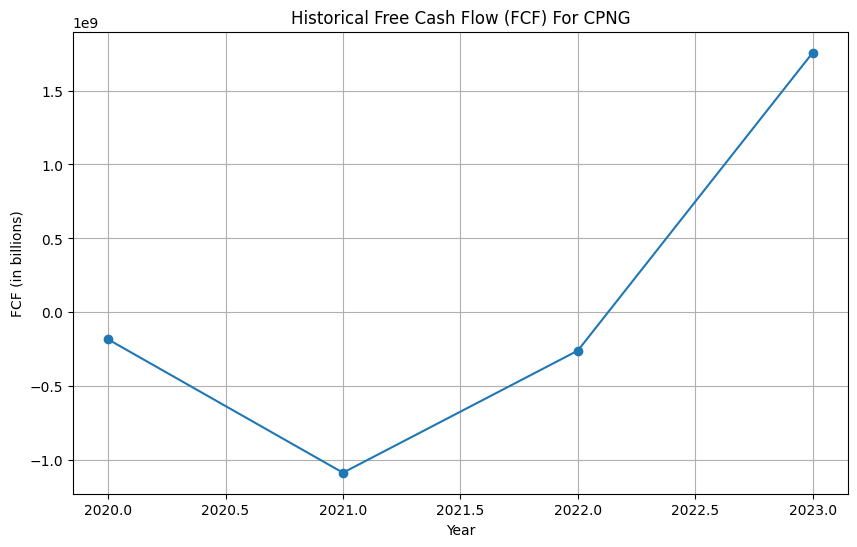

In [16]:
# Set option to avoid the FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# Plotting historical and future FCF
plt.figure(figsize=(10, 6))

# Plot historical FCF
plt.plot(fcf.index.year, fcf.values, marker='o', label='Historical FCF')

# Set title and labels
plt.title(f'Historical Free Cash Flow (FCF) For {ticker}')
plt.xlabel('Year')
plt.ylabel('FCF (in billions)')

# Show the plot
plt.grid(True)
plt.show()